# Generate Heatmap for fibroblast

In [2]:
import sys
import subprocess

%matplotlib inline
import re
import glob
import os
import sys

import scanpy as sc
import scvelo as scv
import cellrank as cr
import scvi
import numpy as np
import pandas as pd
import pickle as pkl#
import scipy
import sklearn #

import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)

from numpy import cov
from collections import Counter
from collections import defaultdict
from collections.abc import Iterable
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from matplotlib import rcParams

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

rcParams['figure.figsize'] = 20,20

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

import torch
print('cuda availability : {}'.format(torch.cuda.is_available()))
print('cuda count : {}'.format(torch.cuda.device_count()))
print(torch.version.cuda)

cuda availability : False
cuda count : 0
11.7


In [3]:
filename = "/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/scvelo_fibro_final_palantir_pseudotime.h5ad"
adata = sc.read(filename)


In [4]:
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_fibro_palantir_lineagedrivers_Dermalcondensate.csv'
Dermalcondensate =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_fibro_palantir_lineagedrivers_Dermalpapilla.csv'
Dermalpapilla =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_fibro_palantir_lineagedrivers_Predermalcondensate.csv'
Predermalcondensate =  pd.read_csv(filename, sep = ',')


In [16]:

filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230705_fibro_palantir_lineagedrivers_pear1fibroblast.csv'
pear1fibroblast =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_fibro_palantir_lineagedrivers_WNT2fibroblas.csv'
WNT2fibroblas =  pd.read_csv(filename, sep = ',')
filename = '/nfs/team298/ew17/fetal_skin/5_230523_SK_trajectories/A1_V1_fskin_fibro_traj/ew/20230712_fibro_palantir_lineagedrivers_Myofibroblasts.csv'
Myofibroblasts =  pd.read_csv(filename, sep = ',')


In [22]:
first = Dermalcondensate['Unnamed: 0'].head(50).tolist()
second = Dermalpapilla['Unnamed: 0'].head(50).tolist()
third = Predermalcondensate['Unnamed: 0'].head(50).tolist()
joined_list = [*first, *second, *third]  
#remove duplicates from list
joined_list = list(dict.fromkeys(joined_list))


In [23]:
first = pear1fibroblast['Unnamed: 0'].head(100).tolist()
second = WNT2fibroblas['Unnamed: 0'].head(50).tolist()
joined_list_fibro = [*first, *second]  

#remove duplicates from list
joined_list_fibro = list(dict.fromkeys(joined_list_fibro))


In [8]:
var_name = 'joint_annotation_20220202'


In [9]:
def obs_key_wise_subsampling(adata, obs_key, N):
    '''
    Subsample each class to same cell numbers (N). Classes are given by obs_key pointing to categorical in adata.obs.
    '''
    counts = adata.obs[obs_key].value_counts()
    # subsample indices per group defined by obs_key
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N, replace=False) for group in counts.index]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

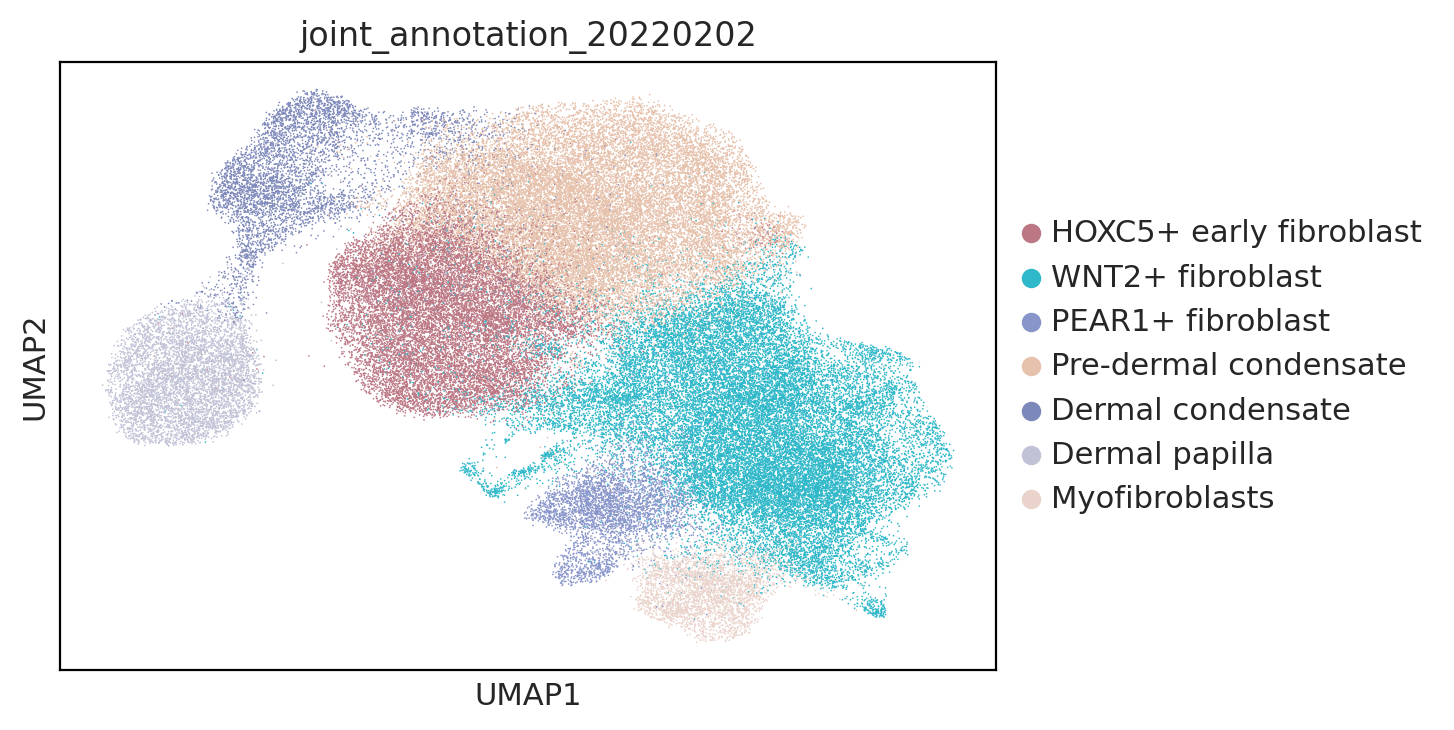

In [10]:
colors_organoid_keratinocytes=['#D72229',  '#8F66A9', '#BABC26', '#8C5A4F', '#7E7E7F','#D179B0', '#CEB08D' ]
colors_organoid_endothelium=['#7D88BA', '#C0C2D6', '#BC7784', '#E6C1AB', '#8895CB', '#EAD3CB','#2EB8C9']
colors_organoid_fibroblast=['#7D88BA', '#C0C2D6',  '#BC7784', '#2EB8C9']
colors_fibroblast=['#BC7784', '#2EB8C9', '#8895CB', '#E6C1AB', '#7D88BA', '#C0C2D6','#EAD3CB']
colors_endothelium=[]
colors_keratinocytes=['#CEB08D', '#D72229', '#D179B0', '#BABC26', '#CEB08D', '#7E7E7F', ' #8C5A4F']

colors = colors_fibroblast
adata.uns[var_name+'_colors'] = colors
sc.pl.umap(adata, color=var_name)
#7D88BA C0C2D6 BC7784
#colors_fibroblast=['#BC7784', '#2EB8C9', '#BC7784', '#E6C1AB', '#8895CB', '#EAD3CB','#2EB8C9']

In [11]:
colors_pcw=['#4f3210', '#895921', '#bd904c', '#e3d09b', '#f4eedb', '#dfeeec', '#a5d5cd', '#5ea099', '#2e6963','#163b30']

colors = colors_pcw
adata.uns['pcw'+'_colors'] = colors


In [12]:
colors_pcw=['#67001f', '#b2182b', '#d6604d', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#053061', '#4d4d4d','#1a1a1a']

colors = colors_pcw
adata.uns['pcw'+'_colors'] = colors

In [13]:
adata_sub = obs_key_wise_subsampling(adata, var_name, 1000)


In [18]:

df = pd.DataFrame(joined_list)


In [19]:
df = pd.DataFrame(joined_list)

df.to_csv('Fibroblasts_dermalpapilla.csv')


/home/jovyan/scvelo/scvelo/plotting/heatmap.py:125: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"{col}_categorical"] = pd.Categorical(cat_col)


saving figure to file ./figures/scvelo_heatmap_20230731_Heatmap_fibroblast_2.pdf


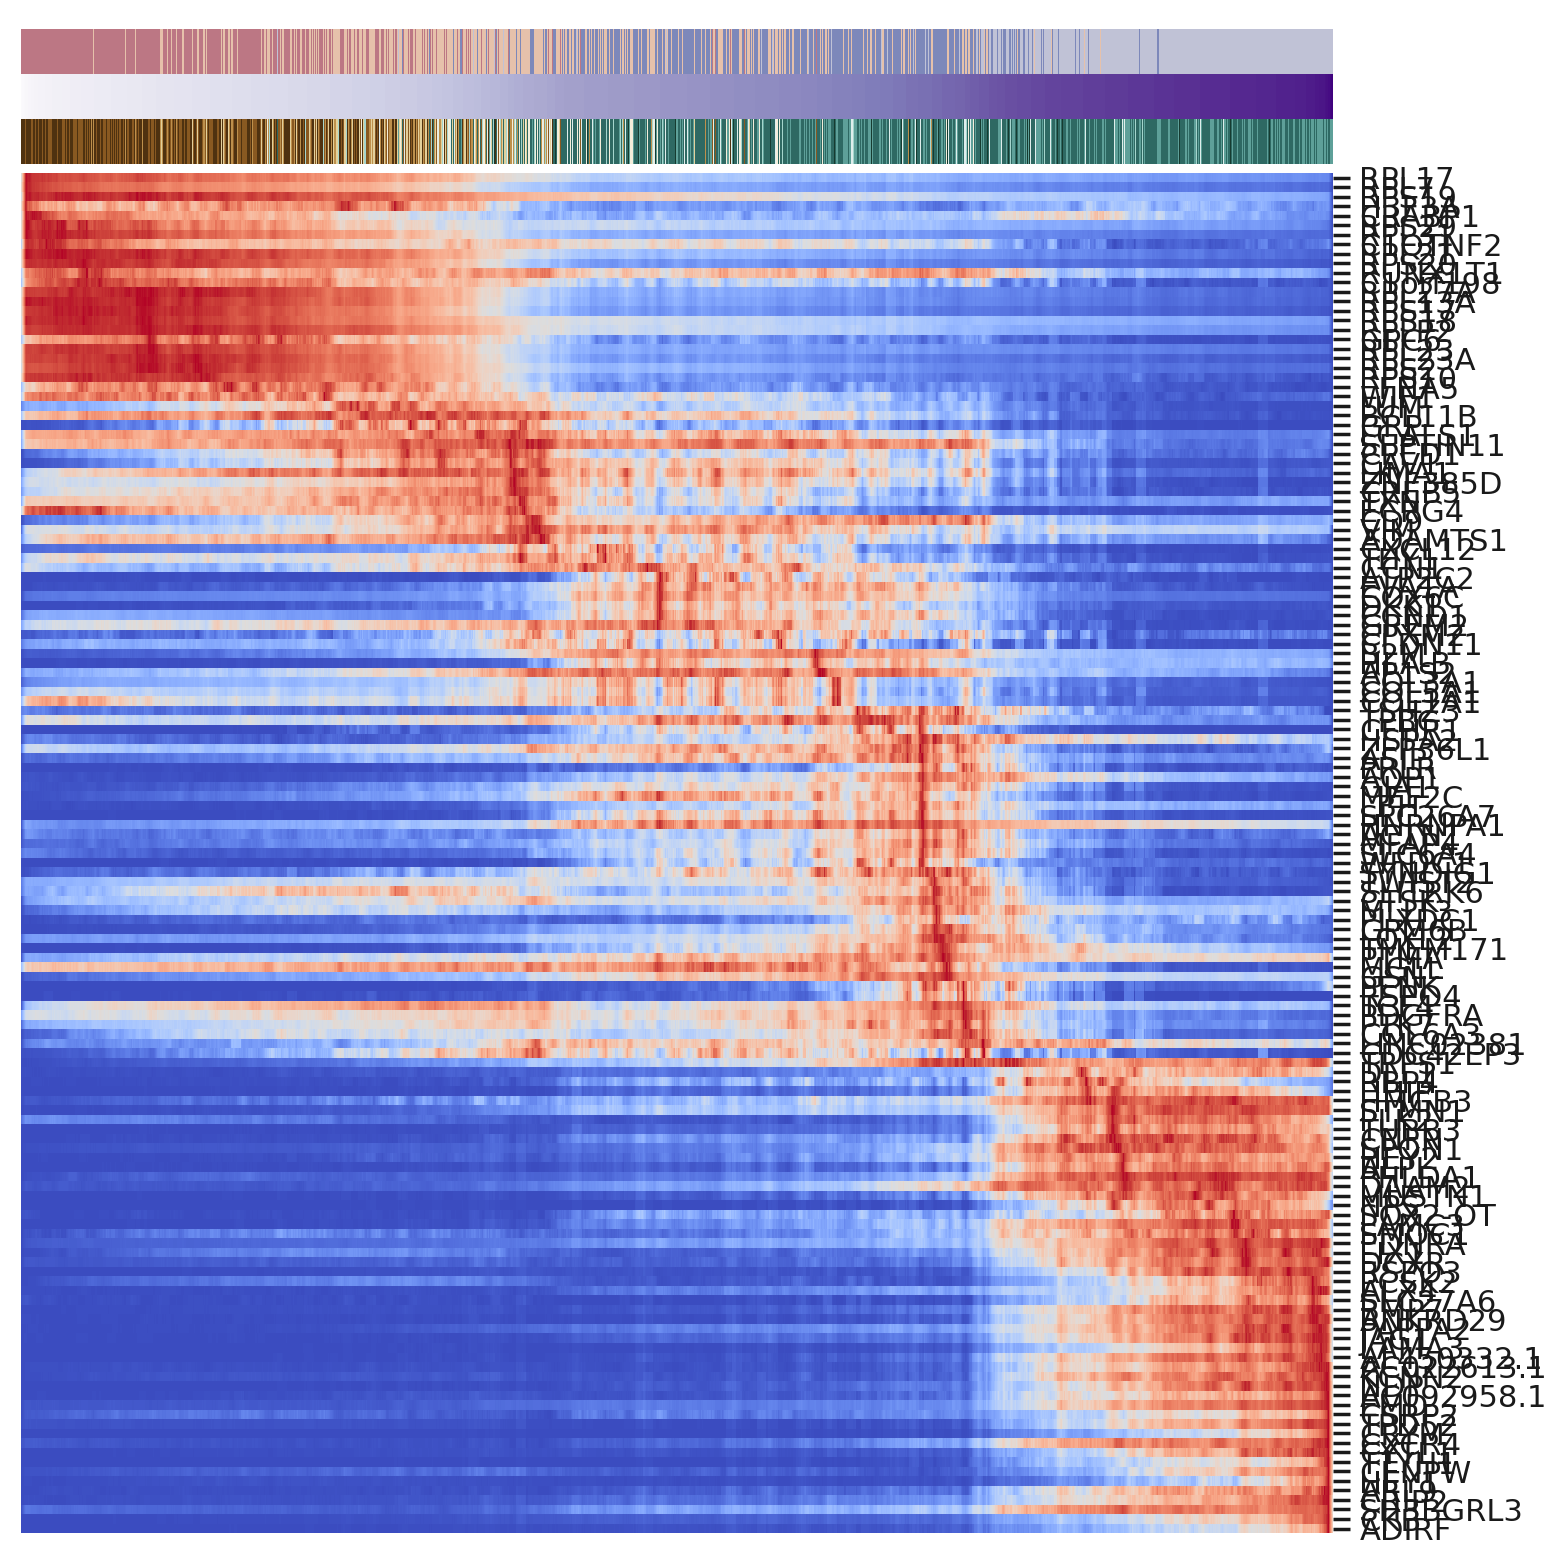

In [98]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
scv.pl.heatmap(adata_sub[adata_sub.obs[var_name].isin(['HOXC5+ early fibroblast', 'Pre-dermal condensate', 'Dermal condensate', 'Dermal papilla'])], 
               var_names=joined_list, sortby='latent_time', 
               color_map='coolwarm',
               col_color=[var_name, 'latent_time', 'pcw'], palette=('Purples'),
               n_convolve=30, standard_scale=0, sort=True, 
               colorbar=None, col_cluster=False, row_cluster=False, yticklabels=True, figsize=(8,8), save="20230731_Heatmap_fibroblast_2.pdf")

/home/jovyan/scvelo/scvelo/plotting/heatmap.py:125: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"{col}_categorical"] = pd.Categorical(cat_col)


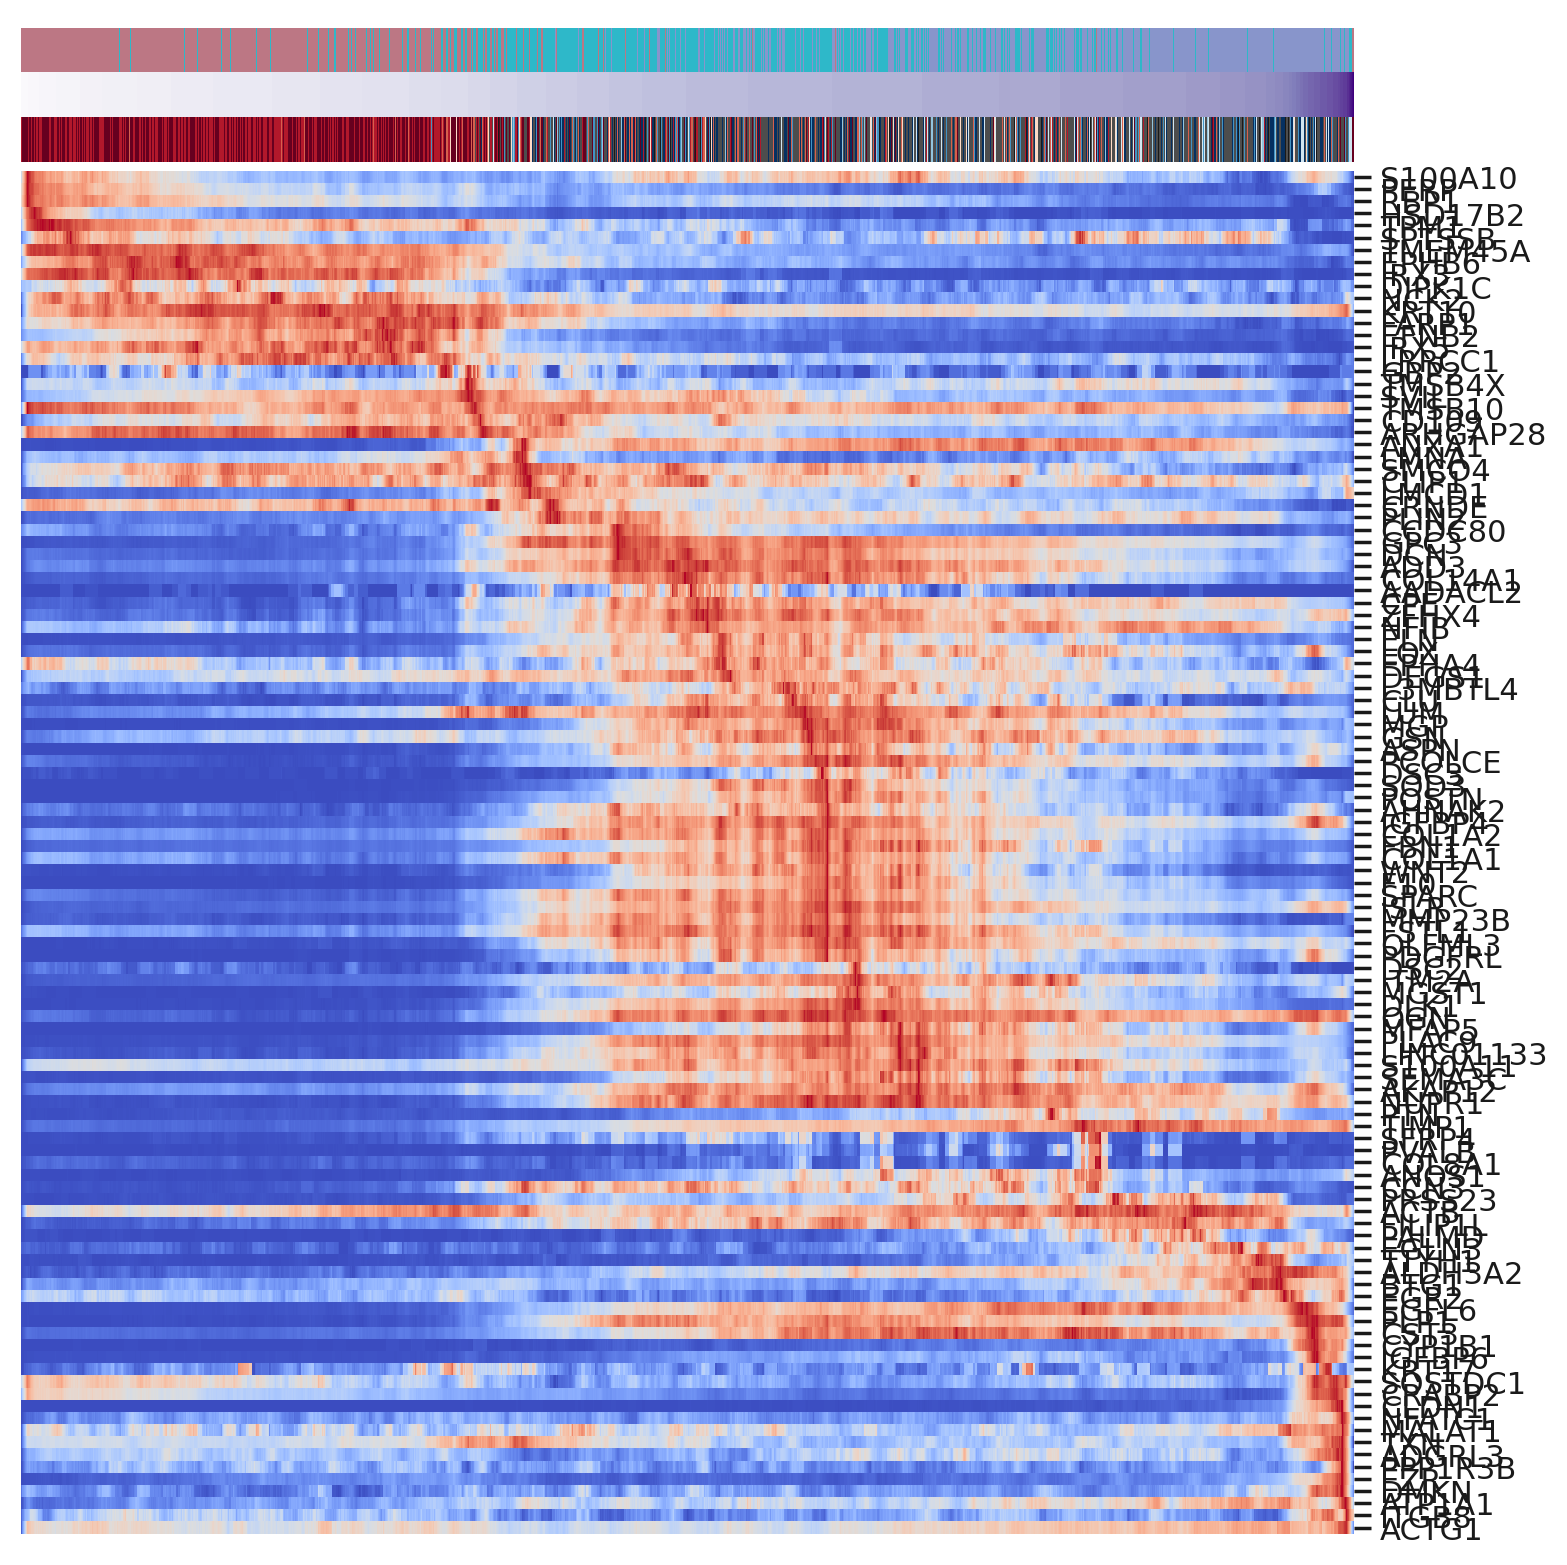

In [27]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
scv.pl.heatmap(adata_sub[adata_sub.obs[var_name].isin(['HOXC5+ early fibroblast', 'WNT2+ fibroblast', 'PEAR1+ fibroblast'])],
                var_names=joined_list_fibro, sortby='VelocityPalantir_matrix_pseudotime', 
               color_map='coolwarm',
               col_color=[var_name, 'VelocityPalantir_matrix_pseudotime', 'pcw'], palette='Purples',
               n_convolve=30, standard_scale=0, sort=True,  yticklabels=True,
               colorbar=None, col_cluster=False, row_cluster=False, figsize=(8,8))

